In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
!cat /proc/meminfo

MemTotal:       13335192 kB
MemFree:         2222208 kB
MemAvailable:   12294072 kB
Buffers:          165188 kB
Cached:          9868544 kB
SwapCached:            0 kB
Active:           796740 kB
Inactive:        9610052 kB
Active(anon):     402332 kB
Inactive(anon):   187884 kB
Active(file):     394408 kB
Inactive(file):  9422168 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               796 kB
Writeback:             0 kB
AnonPages:        371148 kB
Mapped:           154672 kB
Shmem:            254972 kB
Slab:             618812 kB
SReclaimable:     581428 kB
SUnreclaim:        37384 kB
KernelStack:        3728 kB
PageTables:         5960 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667596 kB
Committed_AS:    2197104 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:      2048 kB
ShmemHugePages:  

In [4]:
!pip3 install torch torchvision
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
# !pip3 install --no-cache-dir -I pillow

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59002000 @  0x7ffa494b01c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 3.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import os
os.chdir("drive/Collab/deep_dream_pytorch")

In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import scipy.misc
import json
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [0]:
def preprocess(image):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
#   image = np.transpose(image, (2,0,1))
  transform = transforms.Compose([  transforms.ToPILImage(),
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    normalize
  ])
  image = Variable(transform(image).unsqueeze(0).cuda())
  return image

def predict(image):
  _, index = model(image).data[0].max(0)
#   print(index.item())
  return str(index.item()), labels[str(index.item())][1]

def postprocess(image):
  return image * torch.Tensor([0.229, 0.224, 0.225]).cuda() + torch.Tensor([0.485,0.456,0.406]).cuda()

def load_image(path):
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   image = image/[255.,255.,255.]
  axis('off')
  imshow(image)
  return image

def gray(image):
  return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

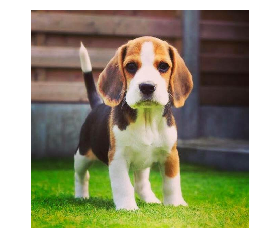

In [37]:
dog = load_image('beagle.jpg')

In [16]:
model = models.vgg16(pretrained=True)
model = model.cuda()
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /content/.torch/models/vgg16-397923af.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
with open('imagenet_class_index.json') as labels:
  labels = json.load(labels)

In [0]:
dog = preprocess(dog)

In [47]:
print(predict(dog))

('162', 'beagle')


In [0]:
modules = list(model.features.modules())

In [0]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    shape = image.shape[0]
    image = torch.sum(image, dim=0, keepdim=True)
    image = torch.div(image, shape)
#     print(shape)
    return image

In [0]:
#Layer Activations:

def activations(image):
  outputs = []
  names = []
  out_im = []
  for layer in modules[1:]:
#     print(layer, image.shape)
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
    
  for i in outputs:
    i = i.squeeze(0)
#     print(i.size())
    grayscale = to_grayscale(i).squeeze(0)
    i = grayscale.data.cpu().numpy()
#     print(i.shape)
    out_im.append(i)
    
  fig = figure()
  rcParams["figure.figsize"]=(30,50)
  
  for i in range(len(out_im)):
#     print(out_im[i].shape)
    
    a = fig.add_subplot(8,4,i+1)
#     img = np.transpose(out_im[i],(1,2,0))
#     print(img.shape)
    imshow(1-out_im[i])
    axis('off')
    a.set_title(names[i].partition('(')[0], fontsize=30)
    

>>>>>> # Total Activations of Each Layer





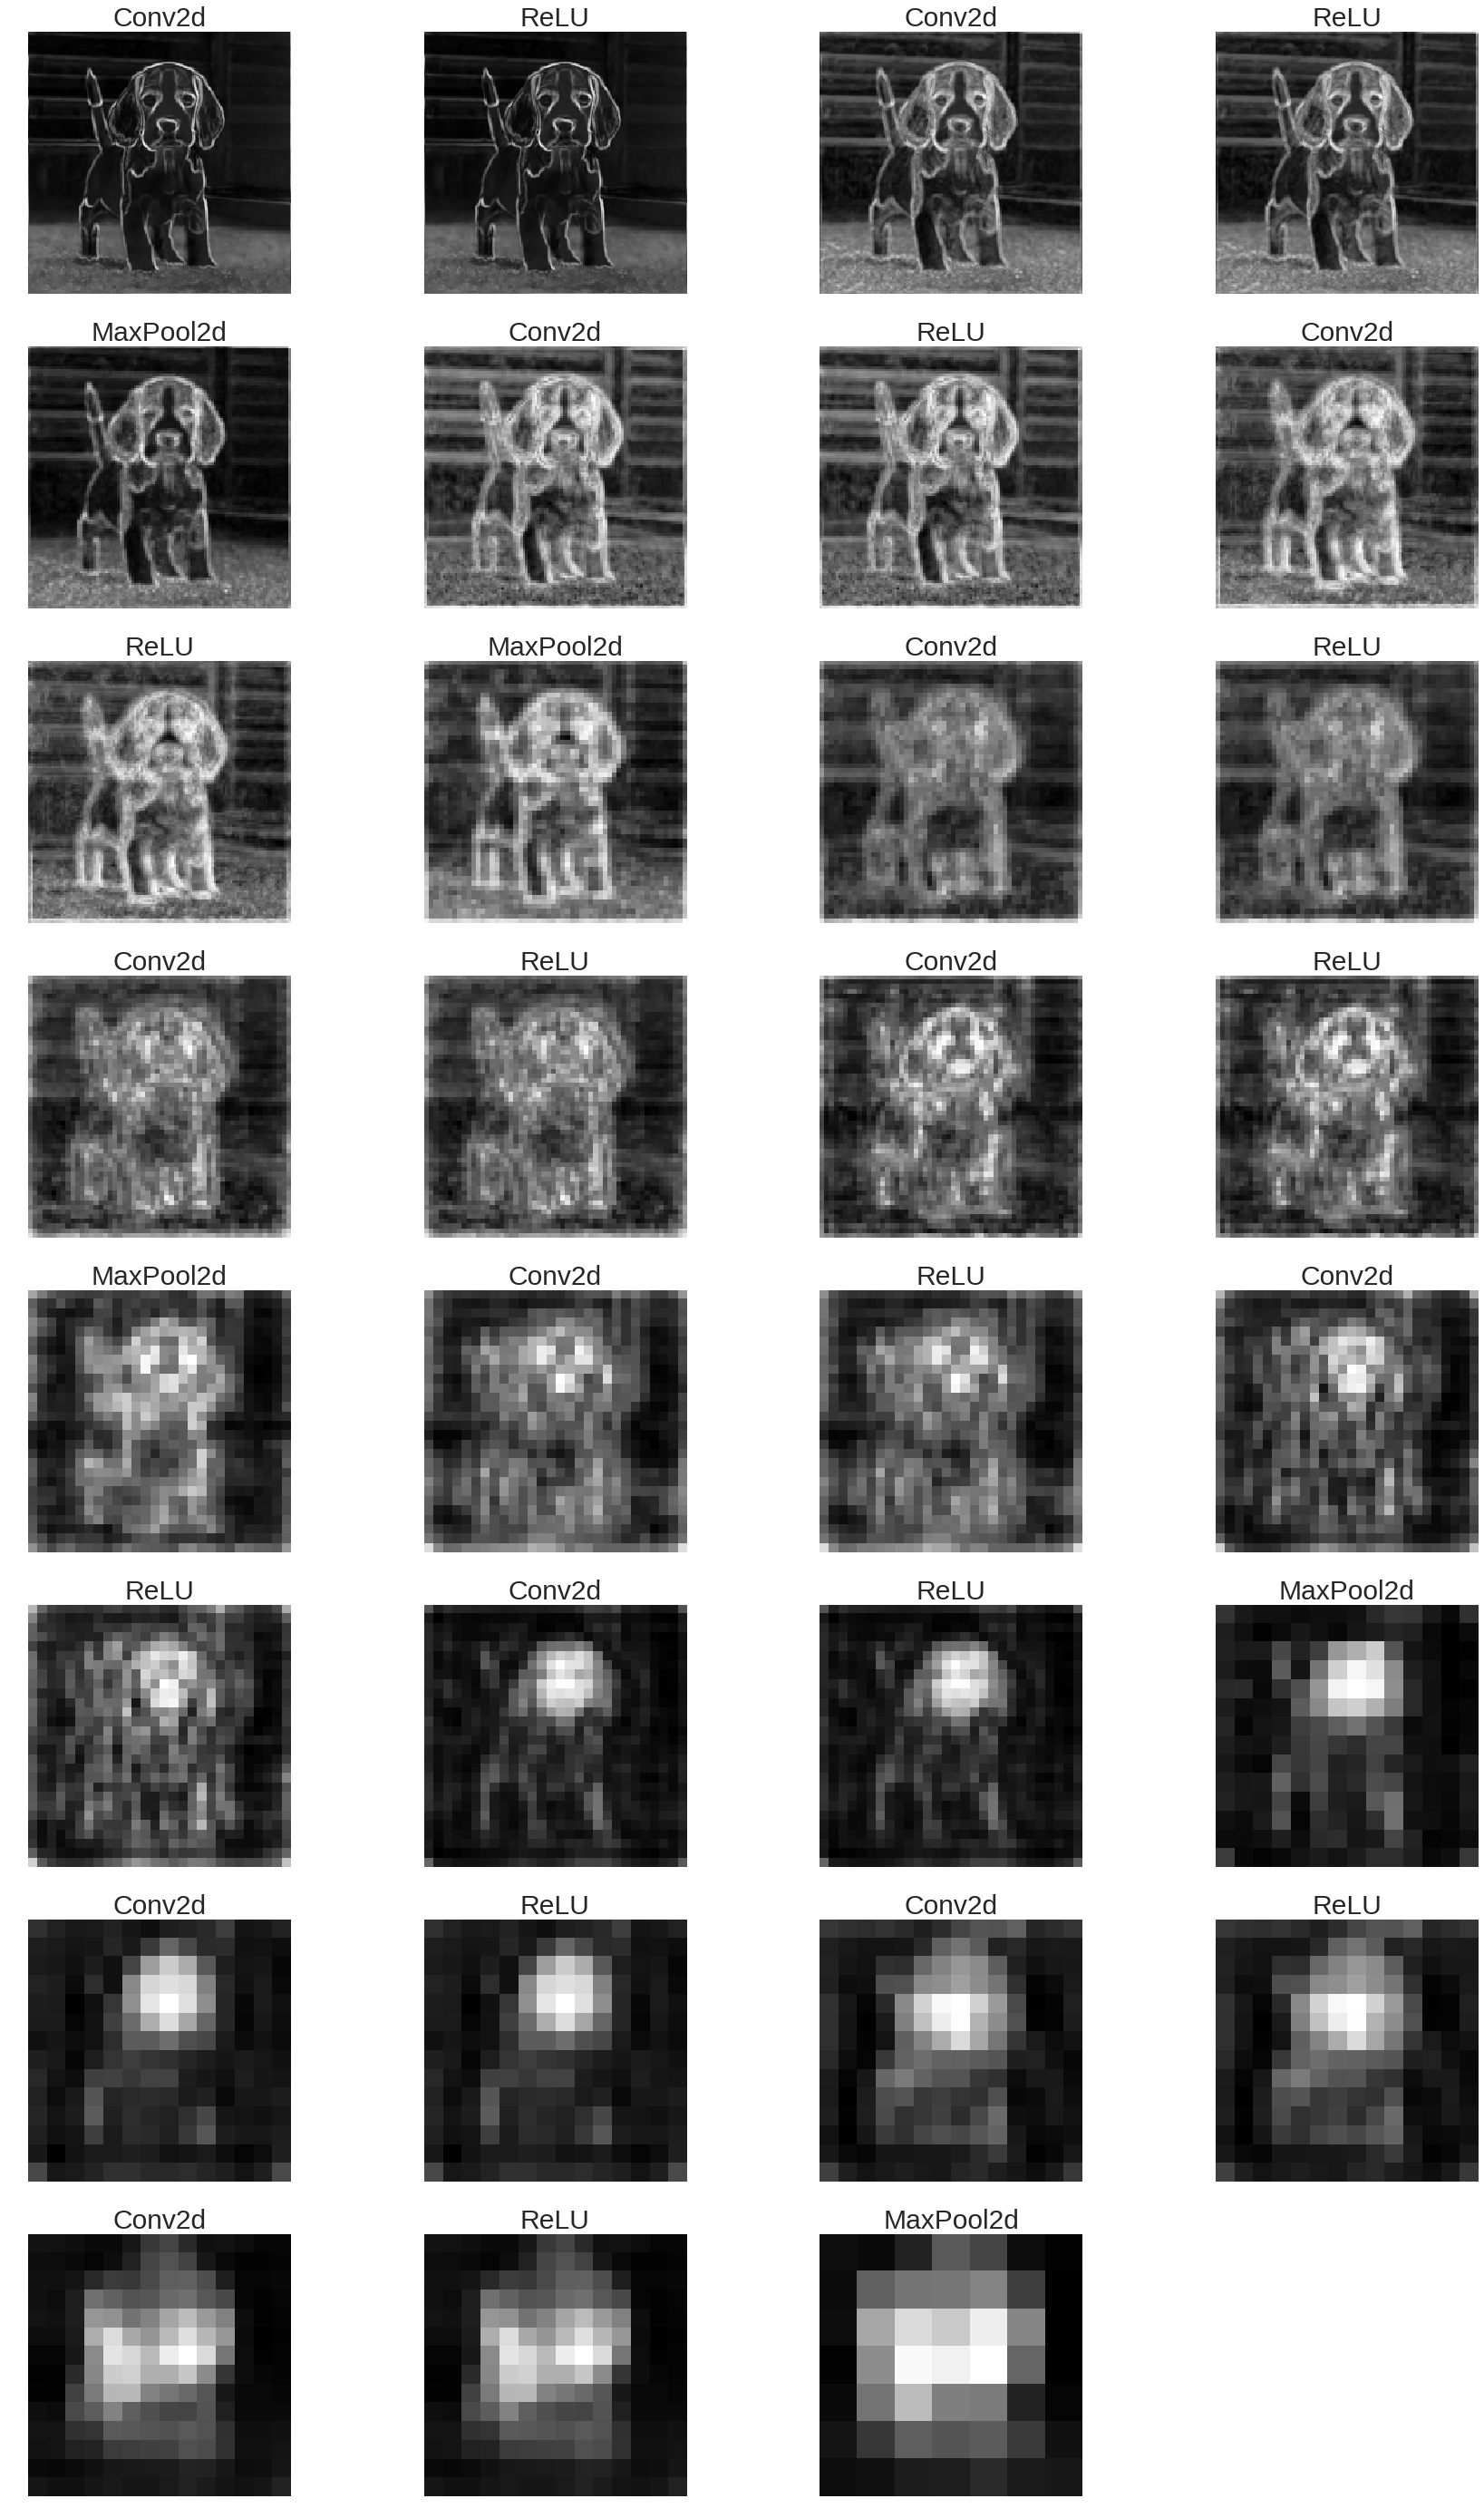

In [143]:
# print(dog.shape)
activations(dog)

# Observations:
- ReLU does not show any noticable effects. Can they be removed at test time?
- While it seems MaxPool is great for earlier layers, but should not be used in later layers, it's actually opposite, since information loss in the activation region corresponds to information gain in the feature/weight region.
- Thus while it seems that using maxpool in earlier layers only removes redundant features, the case is that in the weight region, it's the final layer weights that are redundant rather than the earlier ones.
- Although activations are getting gross and non-interpretable, weights/neurons/detectors are getting more and more specific.
- For an all conv network, the final activations in the last layer should correspond to the sum of all the class-specific occlusion maps.

In [0]:
def filter_activations(image, layer): #Choose a layer to show activation of each of its filter seperately
  